# Assignment 7: SN1a and the Nobel Prize

Bryan J Miller

Phy 154

May 30, 2016

# 1 Cosmology with Supernovae Ia

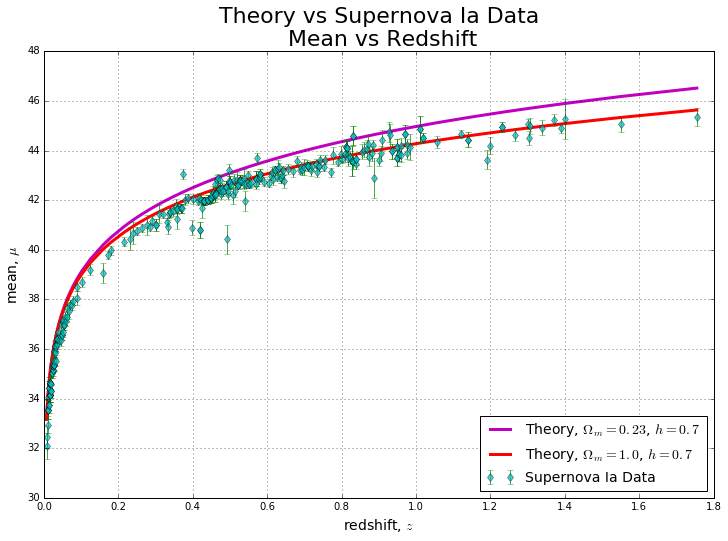

In [12]:
# load libraries
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import emcee

# plot within notebook
%matplotlib inline

# load data
z_data = np.genfromtxt('SN.dat', skip_header=1, usecols=(1))
mu_data = np.genfromtxt('SN.dat', skip_header=1, usecols=(2))
err_data = np.genfromtxt('SN.dat', skip_header=1, usecols=(3))

'''
We need this data sorted by redshift so that chi2 function properly
calculates each point. Otherwise it would compare points at different 
redshifts. Also, this allows us to use the redshift data as our z, 
instead creating one with linspace.
'''

# copies of data placed in numpy arrays for sorting
z = np.array(z_data)
mu = np.array(mu_data)
err = np.array(err_data)

'''
So below we first sort z, so that it runs from smallest to largest.
This we use a for loop to sort mu and err (sigma) by comparing how
z_data differs from z.
'''
# sorting data by redshift
z.sort()
for i in range(len(z)):
    for j in range(len(z)):
        if z_data[j] == z[i]:
            mu[i] = mu_data[j]
            err[i] = err_data[j]

# constants
OmegaM0 = 0.23
OmegaM1 = 1.0
h0 = 0.7
steps = len(z) # number of data points

# initial parameters for question 3
params0 = [h0, OmegaM0]
params1 = [h0, OmegaM1]

###### FUNCTIONS ######
'''
Note that all the functions must take z and params.
Without this it becomes extremely difficult to find
the best fit parameters.
'''
# integrand to calculate D_c
def f(z, params):
    h, OmegaM = params # this line is needed in all functions
    OmegaL = 1.0-OmegaM # don't do this outside the function since you have multiple OmegaM's
    f = (3000.0/h)/(np.sqrt(OmegaM*np.power((1.0+z),3.0)+OmegaL)) # this is the entire integrand
    return f

# integrating to get D_c
def Dc(z, params):
    h, OmegaM = params
    Dc = [] # define this inside the function so that everytime the code is run a new Dc is created
    f_int = lambda z: f(z, params) # integrating f with respect to z
    for i in range(steps): # for loop over all data points
        intEz = integrate.quad(f_int,0.0,z[i]) # this integrates from 0 to z[i]
        Dc.append(intEz[0]) # then that value is appended to the array Dc
    return Dc

# D*_L function, h has been factored out!!!
def DL(z, params):
    h, OmegaM = params
    DL = (1.0+z)*Dc(z, params) # no h!
    return DL

'''
The MU function calls on the DL function, which calls on the Dc function,
which calls on the f function, and all of them depend on z and params (h,OmegaM).
Yes this is elegant as fuck.
'''
# mu function
def MU(z, params):
    h, OmegaM = params
    MU = [] # again, define this inside the function so a new one is created each time
    MU = 25.0 - 5.0*np.log10(h) + 5.0*np.log10(DL(z, params))
    return MU

# plotting theory verses data
plt.figure(figsize=(12,8))
plt.plot(z, MU(z, params0), 'm', linewidth=3, label='Theory, $\Omega_{m} = 0.23$, $h = 0.7$')
plt.plot(z, MU(z, params1), 'r', linewidth=3, label='Theory, $\Omega_{m} = 1.0$, $h = 0.7$')
plt.errorbar(z, mu, yerr=err, fmt='cd', ecolor='g', alpha=0.7, label='Supernova Ia Data')
plt.legend(fontsize=14, loc=4)
plt.grid(True)
plt.xlabel('redshift, $z$',fontsize=14)
plt.ylabel('mean, $\mu$',fontsize=14)
plt.title('Theory vs Supernova Ia Data\n Mean vs Redshift',fontsize=22)
plt.show()

# 2 DATA 

(a) The 'Mean vs Redshift' plot above looks very similar to figure (6) from Riess et al.

(b) There's definitely a difference. $\Omega_{m} = 1.0\ $ seems to fit the data much better than $\Omega_{m} = 0.23\ $.

Optimization terminated successfully.
         Current function value: 384.814755
         Iterations: 34
         Function evaluations: 66


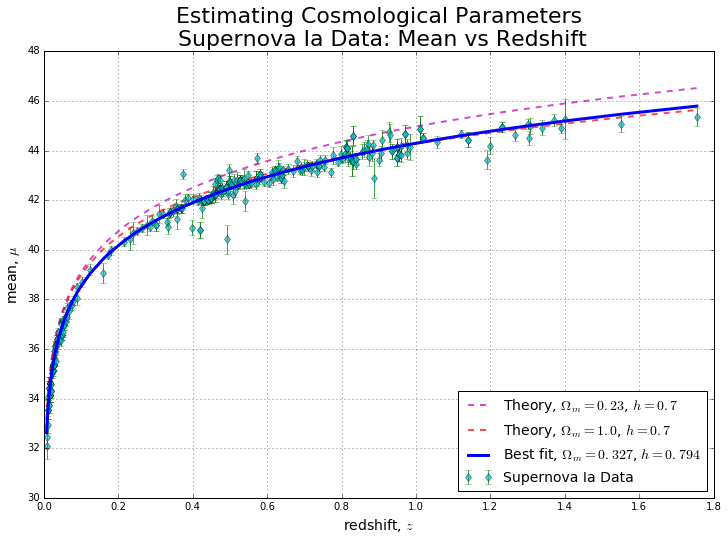

Theory when h = 0.7:
Chisquared for Omega_m = 0.23: 2622.52471231
and reduced chisquared of: 8.98124901476 - not a good fit

Chisquared for Omega_m = 1.0: 906.776859404
and reduced chisquared of: 3.10540020344 - better, but still not a good fit

Best fit Chisquared (fmin): 384.814754851
Where, h = 0.793770871766 and Omega_m = 0.326513192203
and reduced chisquared of: 1.31785874949 - a very good fit


In [11]:
# Chisquared
def chi2(params, args=(z,mu,err)): # args=z also works just fine since mu and err are globally defined and don't change
    h, OmegaM = params
    MU0 = MU(z, params) # must create MU array inside this function
    chi2 = 0.0
    for i in range(steps):
        chi2 += np.power((mu[i]-MU0[i]),2.0)/np.power(err[i],2.0) 
    return chi2

# fmin on chisquared
xopt = optimize.fmin(chi2, params1)

# question 3 plot
plt.figure(figsize=(12,8))
plt.plot(z, MU(z, params0), 'm--', linewidth=2, alpha=0.7, label='Theory, $\Omega_{m} = 0.23$, $h = 0.7$')
plt.plot(z, MU(z, params1), 'r--', linewidth=2, alpha=0.7, label='Theory, $\Omega_{m} = 1.0$, $h = 0.7$')
plt.errorbar(z, mu, yerr=err, fmt='cd', ecolor='g', alpha=0.7, label='Supernova Ia Data')
plt.plot(z, MU(z, xopt), 'b', linewidth=3, label='Best fit, $\Omega_{m} = 0.327$, $h = 0.794$')
plt.legend(fontsize=14, loc=4)
plt.grid(True)
plt.xlabel('redshift, $z$',fontsize=14)
plt.ylabel('mean, $\mu$',fontsize=14)
plt.title('Estimating Cosmological Parameters\n Supernova Ia Data: Mean vs Redshift',fontsize=22)
plt.show()

# printing chisquared results
print "Theory when h = 0.7:"
print "Chisquared for Omega_m = 0.23: "+str(chi2(params0, args=(z,mu,err)))
print 'and reduced chisquared of: ' + str(chi2(params0, args=(z,mu,err))/steps) + ' - not a good fit\n'
print "Chisquared for Omega_m = 1.0: "+str(chi2(params1, args=(z,mu,err)))
print 'and reduced chisquared of: ' + str(chi2(params1, args=(z,mu,err))/steps) + ' - better, but still not a good fit'

print "\nBest fit Chisquared (fmin): "+str(chi2(xopt, args=(z,mu,err)))
print 'Where, h = ' +str(xopt[0]) + ' and Omega_m = ' +str(xopt[1])
print 'and reduced chisquared of: ' + str(chi2(xopt, args=(z,mu,err))/steps) + ' - a very good fit'

# 3 Estimating parameters

This best fit line can be seen in the plot above, and it is definitely a better fit than the other parameters.
I found this by minimizing chi squared with the scipy.optimize.fmin function.

To varify this we compare chi squared values. Our best fit line gives a chi squared of 1.32, which is very good,
when compared to the other fit lines plotted in problem 2. (results can be seen in the frame above)

The closer the chi suared value is to 1 the better the fit.

This gives h = 0.794 and Omega_M = 0.327 for our parameters.